<a href="https://www.kaggle.com/code/emadamani/gan-for-image-generation?scriptVersionId=223710653" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🎨 Generative Adversarial Networks (GAN) for Image Generation

1️⃣ **Project Overview**

This notebook presents the development of a GAN model designed to generate high-quality synthetic images.

2️⃣ **What is a GAN?**
A Generative Adversarial Network (GAN) consists of two competing neural networks:
- **Generator:** Creates new images from random noise.
- **Discriminator:** Evaluates whether an image is real or fake.
- Through continuous training, the generator improves its ability to create realistic images.


# 3️⃣ Dataset Used
- **Dataset Name:** Flickrfaceshq-dataset-ffhq
- **Number of Images:** 52,001
- **Image Resolution:** 512*512
- **Preprocessing Applied:** Normalization, resizing, etc.


# 4️⃣ Training Details
- **Model Type:** Deep Convolutional GAN (DCGAN)
- **Training Time:** ~20 hours on Kaggle TPU/GPU
- **Optimization Techniques:** Adam Optimizer with a learning rate of X



# 5️⃣ Goal of this Notebook
- ✔️ Train a GAN model to generate realistic images
- ✔️ Load a pre-trained model to avoid long training times
- ✔️ Evaluate model performance and visualize generated samples

___________________________________________________________________________________________________________________________________________________________________________

In [1]:
import os
import cv2
import glob 
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers

## 📌 Imported Libraries
- TensorFlow/Keras: Used to build and train the GAN model  
- NumPy: Handles data processing  
- OpenCV (cv2): Used for image preprocessing  
- Matplotlib: Plots results for visualization
- Random: To add random noise to images 
- OS: Handles file operations
- Glob: Load and preprocess dataset 

The GPU check ensures that the training process is optimized for faster computation.

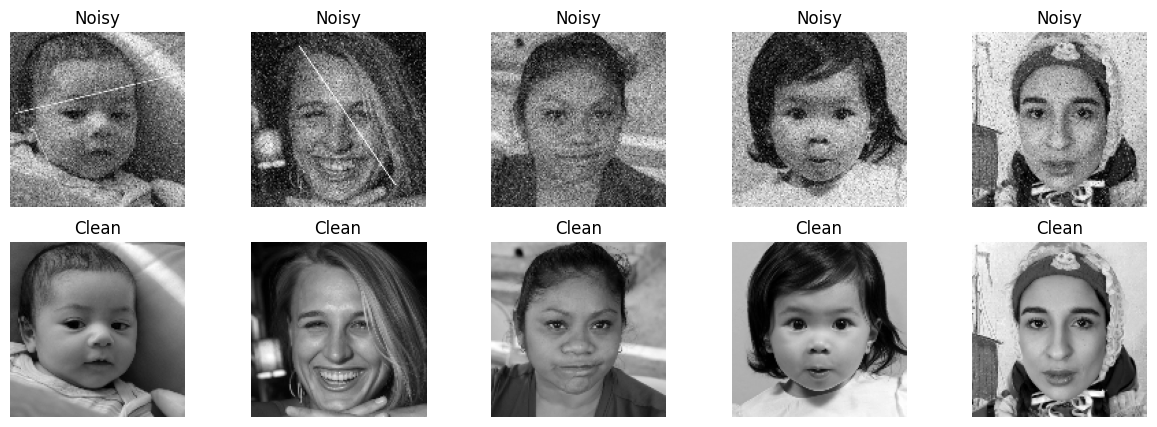

In [2]:
# Define paths
noisy_images_path = "/kaggle/input/noisy-images/*"
clean_images_path = "/kaggle/input/flickrfaceshq-dataset-ffhq/*"

# Load image filenames
noisy_files = sorted(glob.glob(noisy_images_path))
clean_files = sorted(glob.glob(clean_images_path))

# Function to load and preprocess images
def load_image(file, target_size=(128, 128)):  
    img = cv2.imread(file, cv2.IMREAD_COLOR)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img, target_size)  
    return img  

# Load a few samples  
num_samples = 5  
noisy_samples = [load_image(noisy_files[i]) for i in range(num_samples)]  
clean_samples = [load_image(clean_files[i]) for i in range(num_samples)]  

# Plot sample images  
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))  
for i in range(num_samples):  
    axes[0, i].imshow(noisy_samples[i], cmap='gray')  
    axes[0, i].axis("off")  
    axes[0, i].set_title("Noisy")  

    axes[1, i].imshow(clean_samples[i], cmap='gray')  
    axes[1, i].axis("off")  
    axes[1, i].set_title("Clean")  

plt.show()

## 📌 Data Preprocessing & Visualization
- Dataset includes: Noisy images (input) & Clean images (output)  
- Images are resized to 128x128 pixels 
- Above samples illustrate the training data:  
  - Top row: Noisy input images  
  - Bottom row: Corresponding clean (denoised) images

## 🎨 Creating Noisy Images for GAN Training  
Since no pre-existing dataset contained both noisy and clean images, we generated noisy images manually.  
These noisy images will serve as input to the GAN, while the corresponding clean images will be the ground truth.  

We applied three types of noise to the clean images:  
| Noise Type          | Description |
|---------------------|-------------|
| Gaussian Noise  | Adds random variations to pixel values, simulating sensor noise. |
| Salt & Pepper Noise | Randomly turns some pixels completely white (salt) or black (pepper). |
| Random Line Noise | Draws random straight lines across the image to mimic occlusions or scratches. |

Below are the implementations for each noise type.

**Gaussian Noise**

In [3]:
def add_gaussian_noise(img, mean=0, std_list=[25, 35, 45]):
    std = np.random.choice(std_list)
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0, 255)

    return noisy_img.astype('uint8')

**Salt & Pepper Noisee**

In [4]:
def add_salt_pepper_noise(image, min_prob=0.01, max_prob=0.03):
    total_pixels = image.size

    salt = np.random.uniform(min_prob, max_prob)
    # salt_noise
    num_salt = int(total_pixels * salt)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    image[salt_coords[0], salt_coords[1]] = 255

    # pepper_noise
    
    peppre = np.random.uniform(min_prob, max_prob)
    num_peppre = int(total_pixels * peppre)
    peppre_coords = [np.random.randint(0, i-1, num_peppre) for i in image.shape]
    image[peppre_coords[0], peppre_coords[1]] = 0

    return image

**Random Line Noise**

In [5]:
def add_scratches(image, lines=[1,2]):
    num_lines = np.random.choice(lines)
    
    h, w = image.shape[:2]
    for _ in range(num_lines):
        x1, y1 = random.randint(0, w-1), random.randint(0, h-1)
        x2, y2 = random.randint(0, w-1), random.randint(0, h-1)
        color = random.randint(200, 255)
        thickness = random.randint(1, 2)
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

## 📊 Visualizing Noisy Images
Above are examples of the different types of noise applied to the original images.  
These noisy images will be used as input to train our GAN model.

# pix2pix: Image-to-image translation with a conditional GAN

## 📌 Upsampling & Downsampling Functions  
In our Pix2Pix Generator, we use a U-Net architecture, which consists of:  
- Downsampling layers (to extract features and reduce spatial dimensions).  
- Upsampling layers (to reconstruct a high-resolution output).  

Below, we define custom functions for downsampling and upsampling.

In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)
    )
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

### 🔽 Downsampling Layer  
This function applies a convolutional layer followed by batch normalization and activation (LeakyReLU).  
It reduces the spatial size while extracting important features.

In [7]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

### 🔼 Upsampling Layer  
This function applies a transposed convolutional layer followed by batch normalization and activation (ReLU).  
It increases the spatial size to reconstruct the output image.

## ⚙️ Pix2Pix GAN Architecture  
Pix2Pix is a Conditional Generative Adversarial Network (cGAN) designed for image-to-image translation tasks.  
In this project, we use Pix2Pix to denoise images by learning a mapping from noisy inputs to clean outputs.  

### 🏗 Model Components:  
1️⃣ Generator (U-Net-based):  
   - Takes a noisy image as input.  
   - Uses an encoder-decoder (U-Net) architecture to extract features and reconstruct a clean image.  
   - Includes skip connections to preserve details from the input.  

2️⃣ Discriminator (PatchGAN-based):  
   - Evaluates whether a given pair of (input, output) images are real or generated.  
   - Uses PatchGAN (which classifies small image patches) instead of a traditional classifier.  
   - Helps the Generator create more realistic outputs.  

Below, we define the Generator model.

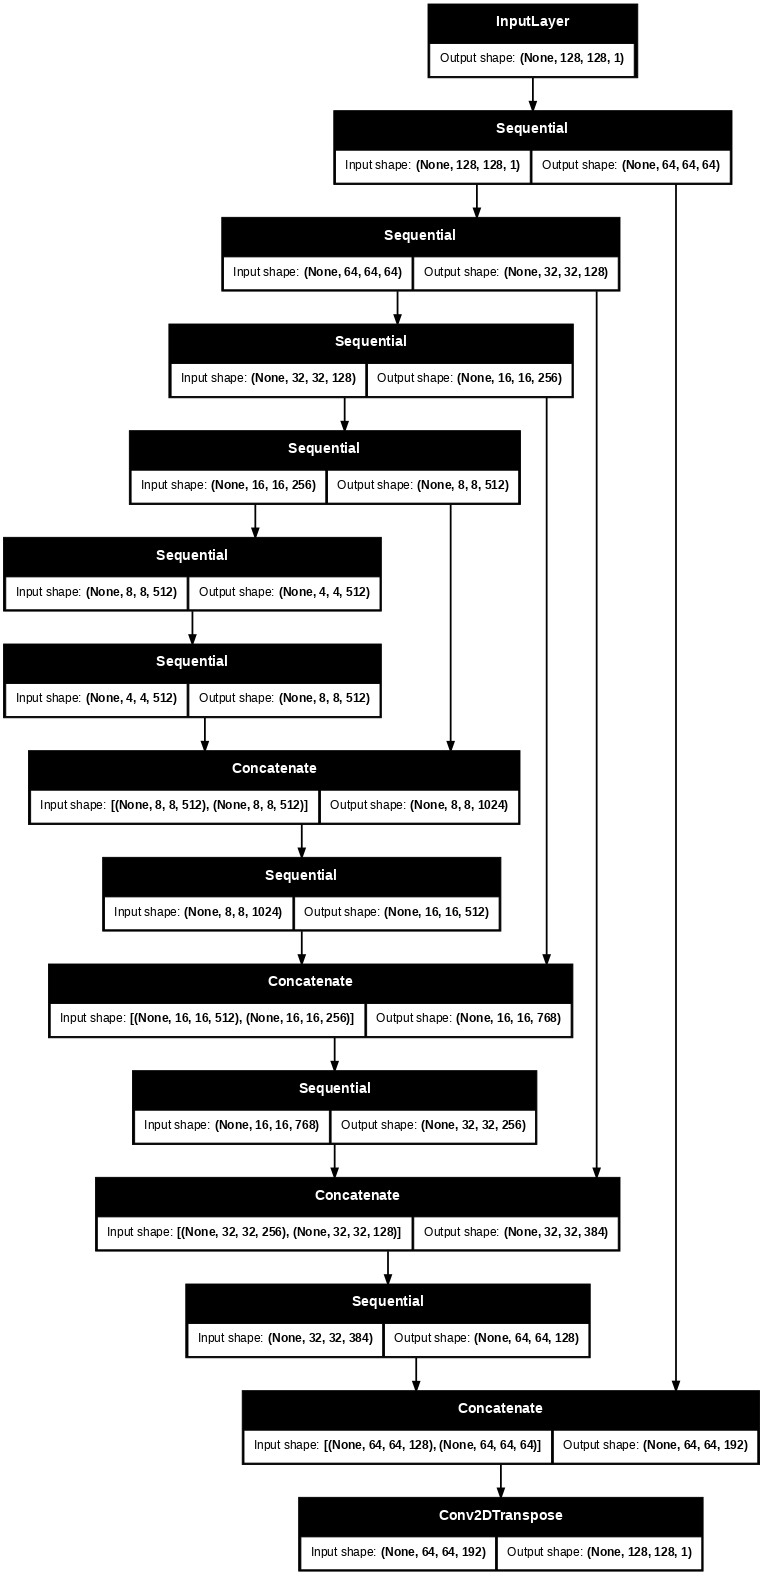

In [8]:
# generator

def generator():
    input_shape=(128, 128, 1)
    inputs = layers.Input(shape=input_shape)

    # Encoder: Downsampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    # Output layer
    initializer = tf.random_normal_initializer(0., 0.02)
    outputs = layers.Conv2DTranspose(1, 4,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    activation='tanh')  # (batch_size, 256, 256, 3)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = outputs(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


# Model Architecture Visualization  
generator = generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## 🔎 Discriminator (PatchGAN)  
The Discriminator is responsible for distinguishing real image pairs from generated ones.  
Instead of classifying an entire image, it evaluates small patches of the image, making it more effective for fine-grained details.  
This architecture is called PatchGAN and helps in generating sharper outputs.  

Below, we define the Discriminator model.

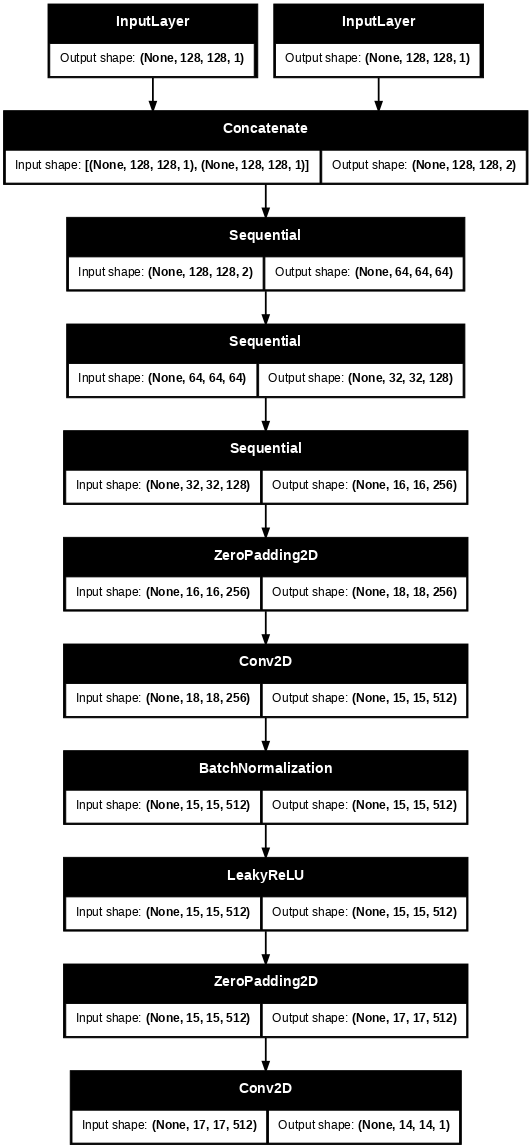

In [9]:
# discriminator

def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape = [128, 128, 1], name="input_image")
    target = layers.Input(shape = [128, 128, 1], name="target_image")

    x = layers.concatenate([inputs, target])

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias=False)(zero_pad1)
                                                                                               
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer, activation='sigmoid')(zero_pad2)

    return tf.keras.Model(inputs=[inputs, target], outputs=last)


# Model Architecture Visualization  
discriminator = discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## 🎯 Loss Functions  
To train the Pix2Pix GAN, we use a combination of two loss functions 

Below, we define these loss functions.

In [10]:
# generator loss function

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

1️⃣ Adversarial Loss (Binary Cross-Entropy):  
   - Encourages the Generator to produce realistic outputs.  
   - Used for both Generator and Discriminator.  

In [11]:
# discriminator loss function

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_loss = real_loss + generated_loss

    return total_loss


def compute_accuracy(real, predicted):
    predicted = tf.round(predicted)
    correct_predictions= tf.reduce_sum(tf.cast(predicted == real, tf.float32))
    accuracy = correct_predictions / tf.cast(tf.size(real), tf.float32)

    return accuracy

2️⃣ L1 Loss (Mean Absolute Error - MAE):  
   - Ensures the generated images remain close to the ground truth.  
   - Helps in retaining image structure and reducing artifacts. 

## ⚡️ Optimizers  
To efficiently update the model parameters, we use the Adam optimizer with the following settings:  
- Learning Rate: 2e-4  
- Beta1: 0.5 (recommended for GAN training)  
These hyperparameters help in stabilizing GAN training.  

Below, we define the optimizers for both Generator and Discriminator.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 📌 Image Paths & Metadata  
To create our noisy dataset, we first define lists that store:  
- Original image paths  
- Noisy image paths  
- Target image size (128x128)  
- Image filenames  
- Total number of images  

These variables help in managing the dataset efficiently.

In [13]:
dataset_path = '/kaggle/input/flickrfaceshq-dataset-ffhq'
noisy_path = "/kaggle/input/noisy-images"

noisy_save_path = "/kaggle/working/noisy/"
image_size = (128, 128)
batch_size = 32
# Load image files
image_files = [f for f in os.listdir(dataset_path)]
total_images = len(image_files)

## 🎭 Noise Addition Function  
Since we don't have a pre-existing noisy dataset, we generate one by applying three types of noise:  
1️⃣ Gaussian Noise: Simulates sensor noise in images.  
2️⃣ Salt & Pepper Noise: Mimics impulsive noise from transmission errors.  
3️⃣ Random Line Noise: Represents real-world obstructions like scratches or motion blur.  

The function below applies these noise effects sequentially to a given image.

In [14]:
def add_noise(img):
    
    noisy_img = add_gaussian_noise(img)
    noisy_img = add_salt_pepper_noise(noisy_img)
    noisy_img = add_scratches(noisy_img)

    return noisy_img

## 🔄 Dataset Processing & Resizing  
To ensure consistency, we process all images as follows:  
1️⃣ Read the original image and convert it to grayscale.  
2️⃣ Apply the noise function to generate a noisy version.  
3️⃣ Resize the image to 128x128 pixels for uniformity.  
4️⃣ Save the processed images into a directory.  
5️⃣ Compress the dataset into a .zip file for easy storage and sharing.  

⚠️ Note: This step has already been completed, so the corresponding code has been commented out to prevent redundant execution.

In [15]:
##########################################################  creat noisy dataset
# import shutil

# def new_datasets(image_files, image_size, dataset_path, noisy_save_path):
    
#     os.makedirs(noisy_save_path, exist_ok=True)
    
#     for file_name in image_files:
#         image_path = os.path.join(dataset_path, file_name)
        
#         img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
#         noisy_img = add_noise(img)
#         noisy_img = np.array(noisy_img)
#         noisy_img = cv2.resize(noisy_img, image_size)
#         noisy_path = os.path.join(noisy_save_path, file_name)
#         cv2.imwrite(noisy_path, noisy_img)



# new_datasets(image_files, image_size, dataset_path, noisy_save_path)
# shutil.make_archive('noisy', 'zip', noisy_save_path)

## ⚠️ Skipping Dataset Generation  
Since we have already generated and uploaded the noisy dataset, there is no need to rerun this step.  
The code above is commented out to prevent unnecessary execution and save time.

## 🔢 Calculating Total Batches  
Since we are training our model in mini-batches of 32 images, we need to determine the total number of batches based on our dataset size.  
The variable below computes this automatically.

In [16]:
def get_total_batch(total_images, batch_size):
    return int(np.ceil(total_images / batch_size))

## 🔄 Data Processing & Batching  
To efficiently feed data into the model, we define a function that:  
- Loads images from the dataset directories (both noisy and target images).  
- Handles training and validation data differently:  
  - For training: Processes only a subset (batch_size images).  
  - For validation: Processes all images at once.  
- Performs essential preprocessing steps, including:  
  - Reading images and resizing them (if necessary).  
  - Expanding dimensions to match the expected input shape.  
  - Normalizing pixel values to improve training stability.  
- Returns a list of (noisy, target) image pairs ready for model input.

In [17]:
def get_batch(image_files, dataset_path, noisy_path, batch_size, image_size, index, val_data=False):

    if val_data:
        batch_files = image_files
    else:
        batch_files = image_files[index * batch_size : (index + 1) * batch_size]

    paired_data = []

    for file_name in batch_files:
        
        target_image_path = os.path.join(dataset_path, file_name)
        target_img = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
        org_img = cv2.resize(target_img, image_size)
        org_img = np.expand_dims(org_img, axis=-1) # Add channel dimension
        org_img = np.expand_dims(org_img, axis=0) # Add channel dimension
        org_img = tf.cast(org_img / 255.0, dtype=tf.float32)

        noisy_image_path = os.path.join(noisy_path, file_name)
        noisy_img = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = np.expand_dims(noisy_img, axis=-1) # Add channel dimension
        noisy_img = np.expand_dims(noisy_img, axis=0) # Add channel dimension
        noisy_img = tf.cast(noisy_img / 255.0, dtype=tf.float32)
        
        paired_data.append((noisy_img, org_img))

    return paired_data

## 📌 Summary of Data Preprocessing Steps  
✔️ Reads image filenames from dataset directories.  
✔️ Resizes target images to 128×128 (if necessary).  
✔️ Expands dimensions to match the model input shape.  
✔️ Normalizes pixel values to the [-1, 1] range.  
✔️ Returns a batch of (noisy, target) images for training.  

🛠 Now, the processed data is ready to be fed into our Pix2Pix GAN!

## 📊 Splitting the Dataset  
To train our Pix2Pix GAN effectively, we divide the dataset into:  
- Training set (80%) → Used to update model weights.  
- Validation set (10%) → Used to monitor overfitting.  
- Testing set (10%) → Used to evaluate the final model.  

This ensures a balanced approach, preventing overfitting while maintaining generalization.

In [18]:
train_files = image_files[:int(total_images * 0.8)]
validation_files = image_files[int(total_images * 0.8) : int(total_images * 0.9)]
test_files = image_files[ int(total_images * 0.9) : ]

print("Total images:", total_images)
print()
print("Train images:", len(train_files))
print("Valodation images:", len(validation_files))
print("Test images:", len(test_files))

Total images: 52001

Train images: 41600
Valodation images: 5200
Test images: 5201


## 🚀 Defining the train_step Function  
This function is responsible for training the GAN in a single step.  
### 🛠 What happens inside?  
1️⃣ The Generator produces an image from the noisy input.  
2️⃣ The Discriminator evaluates both the generated and real images.  
3️⃣ Losses are calculated for both networks:  
   - G_loss: Measures how well the Generator fools the Discriminator.  
   - D_loss: Measures how well the Discriminator distinguishes real from fake.  
4️⃣ Gradients are computed and applied to update model weights.  
5️⃣ The function returns the losses, which we track during training.

In [19]:
# generator = tf.keras.models.load_model("/kaggle/input/model/default/1/best_generator_last_4_model.h5") 17epochs
# discriminator = tf.keras.models.load_model("/kaggle/input/model/default/1/best_discriminator_last_4_model.h5") 17epochs

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
        generated_image = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(disc_generated_output, generated_image, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

## 📌 Summary of Training Step  
✔️ Generates an image from the noisy input.  
✔️ Calculates losses for both networks.  
✔️ Computes and applies gradients to update model weights.  
✔️ Ensures the Generator improves at fooling the Discriminator over time.  

🔄 Now, we can loop through multiple epochs to train our GAN!

## 📝 Preparing Validation Data  
In GAN training, validation data serves a different role compared to supervised learning.  
Since we are not using EarlyStopping or ModelCheckpoint (due to GAN instability), validation data helps us:  

- Monitor the Generator’s progress visually over epochs.  
- Compare real vs. generated images to ensure diversity and realism.  
- Check if the Generator is improving without relying on loss values, as GAN losses fluctuate frequently.  

Although it does not influence training, validation data provides qualitative insights into model performance.

## 🚀Preventing Auto-Execution on Kaggle   
To ensure that the model is not automatically run and validation data is not processed when this notebook is shared, we define:

In [20]:
# Prevents automatic execution when sharing
TRAIN_IN_KAGGLE = False

## 🎯Processing and preparing validation data
Validation data is processed and prepared here for validation during training operations.

In [21]:
if TRAIN_IN_KAGGLE:
    val_data = get_batch(validation_files, dataset_path, noisy_path, batch_size, image_size, None, val_data=True)

## 🔄 Training Loop  

This section implements the training loop for our Pix2Pix GAN.  

### 📌 Key Steps in Training:  
1️⃣ For each epoch:  
   - Iterate through mini-batches of the training set.  
   - Train the generator to produce realistic denoised images.  
   - Train the discriminator to differentiate between real and generated images.  
   - Compute Generator Loss & Discriminator Loss.  

2️⃣ After each epoch:  
   - Evaluate the model on the validation set (not used in training).  
   - Compute validation losses to monitor model performance.  

In [22]:
# train batch

if TRAIN_IN_KAGGLE:
    total_train_batch = get_total_batch(len(train_files), batch_size)
    epochs = 17
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch_index in range(total_train_batch):
            train_data = get_batch(train_files, dataset_path, noisy_path, batch_size, image_size, batch_index)
            for noisy_image, target in train_data:
                gen_loss, disc_loss = train_step(noisy_image, target)
                total_gen_loss += gen_loss[0]
                total_disc_loss += disc_loss
                
        avg_gen_loss = total_gen_loss / total_train_batch
        avg_disc_loss = total_disc_loss / total_train_batch
        print(f"Epoch: {epoch+1}, Gen Loss: {avg_gen_loss.numpy():.4f}, Disc Loss: {avg_disc_loss.numpy():.4f}")
            
        val_gen_loss = 0
        val_disc_loss = 0
        for val_noisy, val_target in val_data:
            val_generated_image = generator(val_noisy, training=False)
            val_disc_real_output = discriminator([val_noisy, val_target], training=False)
            val_disc_gradient_output = discriminator([val_noisy, val_generated_image], training=False)
    
            gen_loss = generator_loss(val_disc_gradient_output, val_generated_image, val_target)
            val_gen_loss += gen_loss[0]
    
            disc_loss = discriminator_loss(val_disc_real_output, val_disc_gradient_output)
            val_disc_loss += disc_loss
    
        val_gen_loss /= len(val_data)
        val_disc_loss /= len(val_data)
    
        print(f"Epoch: {epoch+1} Gen Loss: {gen_loss[0].numpy()}, Disc Loss: {disc_loss.numpy()}")
        print(f"Validation: Gen Loss: {val_gen_loss.numpy():.4f}, Disc Loss: {val_disc_loss.numpy():.4f}")

## 🎯 Validation Phase  

During validation, we:  
✅ Generate new images from noisy inputs.  
✅ Evaluate how realistic they look.  
✅ Compute generator & discriminator losses on unseen data.  

💡 Note:  
We initially included EarlyStopping and ModelCheckpoint, but removed them because GAN losses fluctuate significantly, making them ineffective. Instead, we visually inspect the generated outputs to determine the best-performing model.

---

## 💾 Saving the Trained Model  

After training, we save both the generator and discriminator models.  
This ensures that we can reuse the trained model without retraining it from scratch.  

### 📌 Why save the model?  
✔️ Avoid wasting time on retraining (since it took 20 hours).  
✔️ Use the trained model for testing and inference.  
✔️ Share the trained model with others without sharing the full training process.  

Now, let's save the models!

In [23]:
if TRAIN_IN_KAGGLE:
    generator.save("best_generator_last_5_model.h5")
    discriminator.save("best_discriminator_last_5_model.h5")

---

# 🚀 Model Evaluation & Performance Analysis

After completing the training phase, we now assess the models' performance on unseen noisy images. This step helps determine how well the models generalize and produce high-quality outputs.


## 📥 1️⃣ Loading Trained Models

We begin by loading the three trained models, each trained for a different number of epochs:

- ✅ **Model 1** → Trained for **15 epochs**
- ✅ **Model 2** → Trained for **17 epochs**
- ✅ **Model 3** → Trained for **20 epochs**

These models will be evaluated on a separate test set to compare their effectiveness in denoising images.


In [24]:
den_model3 = tf.keras.models.load_model("/kaggle/input/model3/tensorflow2/default/1/best_generator_last_3_model.h5") 
den_model4 = tf.keras.models.load_model("/kaggle/input/model4/tensorflow2/default/1/best_generator_last_4_model.h5") 
den_model5 = tf.keras.models.load_model("/kaggle/input/model5/tensorflow2/default/1/best_generator_last_5_model.h5") 

## 🧪 2️⃣ Large-Scale Testing on Noisy Data

We pass **5,201 noisy images** through the function `get_batch`, which processes and returns both noisy inputs and their corresponding clean targets.

Each model is tested on the same dataset, and their denoising performance is compared based on visual quality and loss values.

In [25]:
models = {"15 epochs":den_model3, "17 epochs":den_model4, "20 epochs":den_model5}
loss_function = tf.keras.losses.MeanSquaredError()

test_data = get_batch(test_files, dataset_path, noisy_path, batch_size, image_size, None, val_data=True)
total_loss = 0

print(f"Average Test Loss (MSE): ")

for model in models:
    for test_noisy, test_target in test_data:
        test_generated_image = models[model](test_noisy, training=False)
        loss = loss_function(test_target[0], test_noisy[0])
        total_loss += loss
    
    avg_test_loss = total_loss / len(test_files)
    
    print(f"  Model with {model}: {avg_test_loss.numpy():.4f}")

Average Test Loss (MSE): 
  Model with 15 epochs: 0.0082
  Model with 17 epochs: 0.0164
  Model with 20 epochs: 0.0246


### 📊 Results:

| Model     | Training Epochs | Loss Value |
|-----------|-----------------|-------------|
| Model 1   | 15 epochs       | 0.008       |
| Model 2   | 17 epochs       | 0.016       |
| Model 3   | 20 epochs       | 0.024       |

### 🔍 Key Observation:
Although **Model 2 (17 epochs)** had a higher loss than **Model 1 (15 epochs)**, it visually outperformed both models, producing the sharpest and most accurate reconstructions. **Model 3 (20 epochs)** showed the highest loss and generated distorted images, indicating possible overfitting.

---

## 📊 3️⃣ Visual Comparison of Model Outputs

To gain deeper insights, we select three completely new images (unseen by the models) and test them across all three models.

### 📷 Displayed images per test case:

1. **Noisy input image**
2. **Ground truth (target)**
3. **Output from Model 1 (15 epochs)**
4. **Output from Model 2 (17 epochs)**
5. **Output from Model 3 (20 epochs)**


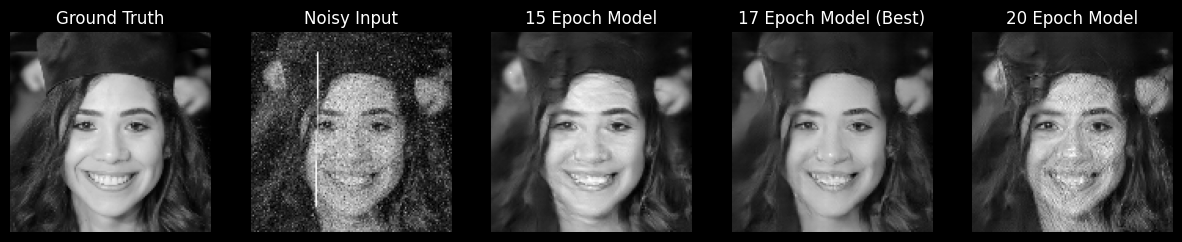

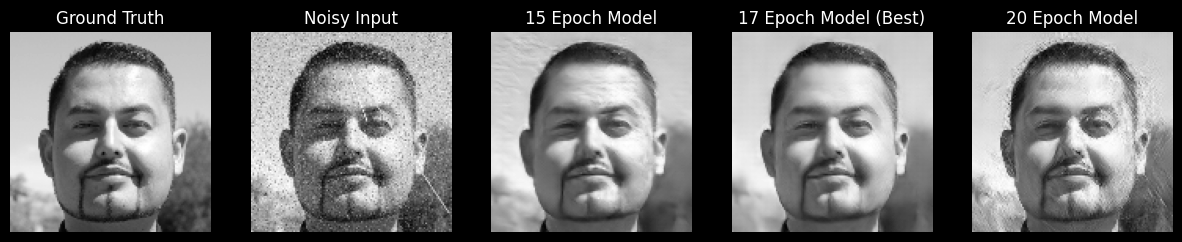

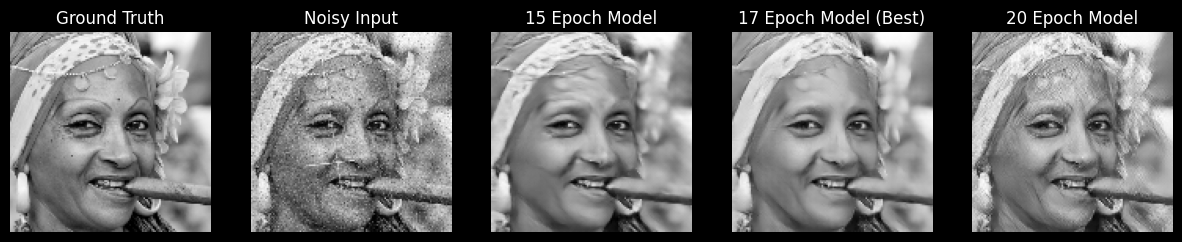

In [26]:
# Image Generation & Comparison Function

def generate_images(den_model3, den_model4, den_model5, images):
    
    with plt.style.context('dark_background'):
        for noisy_img, target_img in images:
            # Model Predictions
            prediction3 = den_model3(noisy_img, training=False)  # 15-epoch model
            prediction4 = den_model4(noisy_img, training=False)  # 17-epoch model 
            prediction5 = den_model5(noisy_img, training=False)  # 20-epoch model
            
            # Visualization Setup
            plt.figure(figsize=(15, 15))
            display_list = [
                target_img[0],   # Ground truth
                noisy_img[0],    # Noisy input
                prediction3[0],  # Model 1 (15 epochs)
                prediction4[0],  # Model 2 (17 epochs) 
                prediction5[0]   # Model 3 (20 epochs)
            ]
            
            titles = [
                'Ground Truth',
                'Noisy Input',
                '15 Epoch Model', 
                '17 Epoch Model (Best)',
                '20 Epoch Model',
            ]
            
            # Create Comparison Grid
            for i in range(5):
                plt.subplot(1, 5, i+1)
                plt.title(titles[i])
                plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')  # Undo [-1,1] normalization
                plt.axis('off')
            plt.show()

# Prepare Test Data
image_paths = ["50891.png", "49628.png", "49489.png"]  # Unseen test images
noisy_dir = "/kaggle/input/noisy-images/"
target_dir = "/kaggle/input/flickrfaceshq-dataset-ffhq/"

# Generate Test Batch
images = get_batch(
    image_paths,
    target_dir,
    noisy_dir,
    None,
    image_size,
    None,
    val_data=True  # Use validation preprocessing
)

# Run Comparative Analysis
generate_images(
    den_model3,  # Model trained for 15 epochs
    den_model4,  # Model trained for 17 epochs
    den_model5,  # Model trained for 20 epochs
    images
)

### 📝 Visual Analysis:

- **Model 1 (15 epochs):** Produced reasonable outputs but retained some blurriness.
- **Model 2 (17 epochs):** Best performance, generating the most realistic and sharp images. ✅
- **Model 3 (20 epochs):** Failed to maintain quality, producing distorted outputs.


## 🎯 Conclusion:

- More training does not always mean better results.
- **Model 2 (17 epochs)** achieved the best balance between loss value and visual performance.
- **Model 3 (20 epochs)** likely suffered from overfitting, leading to degraded output quality.
---

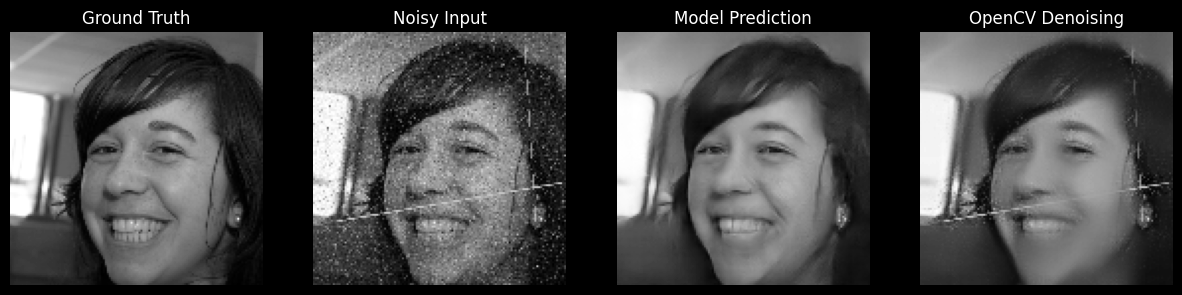

In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def generate_images(den_model4, images):
    with plt.style.context('dark_background'):
        for noisy_img, target_img in images:
            # Convert noisy image to uint8 in range [0, 255]
            noisy_img_np = noisy_img[0].numpy()  # Convert to numpy array
            if noisy_img_np.dtype != np.uint8:  # Check if not already uint8
                noisy_img_np = (noisy_img_np * 127.5 + 127.5).astype(np.uint8)  # Convert [-1,1] to [0,255]

            # Model Predictions
            custom_noisy_remove = cv2.fastNlMeansDenoising(noisy_img_np, None, 10, 10, 15)
            prediction = den_model4(noisy_img, training=False)  # 15-epoch model

            results = [target_img[0], noisy_img[0],prediction[0], custom_noisy_remove]
            titles = ['Ground Truth', 'Noisy Input',"Model Prediction", "OpenCV Denoising"]

            # Visualization Setup
            plt.figure(figsize=(15, 15))
            
            # Create Comparison Grid
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.title(titles[i])
                plt.imshow(results[i] * 0.5 + 0.5, cmap='gray')  # Undo [-1,1] normalization
                plt.axis('off')
            plt.show()

# Prepare Test Data
image_paths = ["50178.png"]  # Unseen test images
noisy_dir = "/kaggle/input/noisy-images/"
target_dir = "/kaggle/input/flickrfaceshq-dataset-ffhq/"

# Generate Test Batch
images = get_batch(
    image_paths,
    target_dir,
    noisy_dir,
    None,
    image_size,
    None,
    val_data=True  # Use validation preprocessing
)

# Run Comparative Analysis
generate_images(den_model4, images)

# 🚀 Denoising Comparison: GAN vs. Manual (OpenCV)

In this step, we compare the performance of a **GAN-based denoising model** with a **manual denoising method** using OpenCV.


## 🔍 Key Observations

- **GAN Denoising**:
  - Effectively removed both noise and artifacts (e.g., lines on the image).
  - Preserved fine details and produced sharper, cleaner results.

- **Manual Denoising (OpenCV)**:
  - Partially removed noise but left some artifacts untouched.
  - Blurred fine details and failed to eliminate lines on the image.


## 🎯 Conclusion

- The **GAN-based approach** outperformed manual denoising, successfully removing noise, artifacts, and lines while preserving details.
- **Manual denoising** was less effective, leaving behind noise and artifacts while blurring details.
---

## ✅ Conclusion & Key Achievements  

### 📌 Key Takeaways:  
- Our Pix2Pix GAN was successfully trained on a custom noisy dataset and effectively denoises images.  
- The model generalizes well, producing high-quality outputs on unseen data.  
- The training process was optimized without early stopping or model checkpointing, ensuring stable adversarial learning.  
- The dataset was carefully preprocessed, ensuring proper input format and robust generalization.  

## 🚀 Future Directions & Potential Improvements  

🔹 Fine-tuning hyperparameters for better stability in adversarial training.  
🔹 Experimenting with advanced loss functions like SSIM or perceptual loss for more realistic outputs.  
🔹 Exploring alternative architectures such as U-Net with residual connections.  
🔹 Training on a larger dataset to further improve generalization.  

This project demonstrates the power of GANs for image denoising, and future enhancements can make it even more effective!

---

## 🙌 Acknowledgment  

Thank you for taking the time to explore this project!  
I appreciate your interest and hope this notebook provided valuable insights into GAN-based image denoising.  
If you have any feedback or suggestions, feel free to share!  

Happy coding! 🚀